# Scikit-learn

---

Student:<br>
Đinh Vũ Gia Hân - 22127098<br>
Đỗ Lê Khoa - 22127195

## Library

In [3]:
import time
import joblib
import pickle
import tracemalloc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (log_loss, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score)

## Load data

The first step is to load the preprocessed data.

In [4]:
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

Because `MLPClassifier` utilizes one-hot encoded labels internally, we convert them to numerical values.

In [5]:
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

## Model design

We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

Since Scikit-learn does not natively support decreasing the learning rate, we must implement it manually. This also necessitates manual implementation of early stopping. Therefore, we will evaluate the model's performance every 10 epochs.

**ReLU Activation Function**

The formula for the ReLU (Rectified Linear Unit) activation function is:

$$
f(x) = \max(0, x)
$$

**Explanation**:
- If \(x $>$ 0\), the output is \(x\).
- If \(x $\leq$ 0\), the output is \(0\).

ReLU helps introduce non-linearity into the network and avoids the vanishing gradient problem commonly encountered with Sigmoid or Tanh activations.


In [6]:
initial_lr = 0.001              # Initial learning rate
patience = 10                   # Maximum number of epochs allowed for non-improvement
min_delta = 0.001               # Minimum change in the monitored quantity to qualify as an improvement
best_val_loss = np.inf          # Best validation loss
best_val_score = 0              # Best validation score
epochs_no_improve = 0           # Count epochs with no improvement
max_epoch = 200                 # Maximum number of epochs
decay_epochs = 10               # Number of epochs after which learning rate decays
# model_path = "best_model.pkl" # Path to save the best model

# Initialize MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(256, 128),  # 2 hidden layers
                    activation='relu',                # Activation function
                    solver='adam',                    # Optimizer
                    batch_size=128,                   # Batch size
                    learning_rate_init=initial_lr,    # Learning rate
                    max_iter=1,                       # Max epochs
                    warm_start=True,                  # Reuse previous fit
                    random_state=42)                  # Stable results

## Selecting Loss Function and Optimizer

We will utilize `CrossEntropyLoss`, the default in Scikit-learn. For optimization, we chose the `Adam` optimizer with a learning rate of 0.001, ensuring efficient and adaptive gradient updates. Additionally, we will reduce the learning rate by a factor of 0.1 every 10 epochs to improve convergence during training.

## CrossEntropyLoss

The formula for CrossEntropyLoss is as follows:

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})
$$

1. **Input**: The logits produced by the model $z_i$.
2. **SoftMax Transformation**: Converts logits into probabilities:
   $$
   \hat{y}_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{C} e^{z_{ik}}}
   $$
3. **Loss Calculation**: The negative log of the predicted probability corresponding to the ground truth class is summed and averaged across all samples.

**Explain**:
It calculates the negative log of the predicted probability corresponding to the true class for each sample and the average loss is computed across the entire dataset. The objective is to minimize the loss, indicating that the model's predictions are getting closer to the true labels.

---

Adam Optimizer

The Adam optimizer updates weights using the following formulas:

### Moment Estimation:
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

### Bias Correction:
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

### Weight Update:
$$
 \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$
1. **Input**: Gradients ($g_t$) calculated during backpropagation.
2. **Moment Calculation**:
   - First moment $m_t$ tracks the mean of past gradients to smooth updates.
   - Second moment $v_t$ tracks the variance to adjust the learning rate dynamically.
3. **Bias Correction**: Corrects for initialization bias in the first few iterations.
4. **Weight Update**: Parameters are updated based on the adjusted learning rates and directions determined by the moments.
<br><br>**Explain**:
- Adam uses two moment estimates:
First Moment (Momentum): stores the exponentially weighted moving average of past gradients.
Second Moment (Variance): stores the exponentially weighted moving average of squared gradients, adjusting the learning rate accordingly.
- Bias Correction: Both moment estimates are bias-corrected to avoid skewed updates, especially in the early stages of training.
- Weight Update: The weights are updated using the bias-corrected moments, with an adaptive learning rate for each parameter.
- Adam combines momentum and adaptive learning rates, helping the model converge faster and more stably during training.

## Model Training

We implemented a `Neural Network` with an `MLP` architecture for training. To ensure efficient training, we integrated `Early Stopping` . This process included loss and accuracy for both training and validation, is logged for each epoch.

In [7]:
train_losses = []       # Training losses
val_losses = []         # Validation losses
val_accuracies = []     # Validation accuracies

# Start measuring time and memory
start_time = time.time()
tracemalloc.start()

# Train model
for epoch in range(0, max_epoch):
    # Set learning rate
    model.set_params(learning_rate_init=initial_lr)

    # Train model
    model.fit(X_train, y_train)

    # Evaluate model
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_accuracy = accuracy_score(y_val, model.predict(X_val)) * 100

    # Log the metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the results
    print(f"Epoch {epoch + 1}/{max_epoch}, Train Loss: {train_loss:.4f}, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
        print("Validation loss improved. Saving model...")
        # joblib.dump(model, model_path)
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    # If the model has not improved for 'patience' epochs
    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

    # Decay learning rate
    if (epoch + 10) % decay_epochs == 0:
        initial_lr *= 0.1

# Stop measuring time and memory
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

Epoch 1/200, Train Loss: 1.7504, Validation Loss: 1.7841, Validation Accuracy: 35.96%
Validation loss improved. Saving model...
Epoch 2/200, Train Loss: 1.6826, Validation Loss: 1.7186, Validation Accuracy: 39.57%
Validation loss improved. Saving model...
Epoch 3/200, Train Loss: 1.6520, Validation Loss: 1.6914, Validation Accuracy: 40.47%
Validation loss improved. Saving model...
Epoch 4/200, Train Loss: 1.6279, Validation Loss: 1.6715, Validation Accuracy: 40.86%
Validation loss improved. Saving model...
Epoch 5/200, Train Loss: 1.6080, Validation Loss: 1.6547, Validation Accuracy: 41.43%
Validation loss improved. Saving model...
Epoch 6/200, Train Loss: 1.5905, Validation Loss: 1.6409, Validation Accuracy: 42.00%
Validation loss improved. Saving model...
Epoch 7/200, Train Loss: 1.5758, Validation Loss: 1.6298, Validation Accuracy: 42.49%
Validation loss improved. Saving model...
Epoch 8/200, Train Loss: 1.5598, Validation Loss: 1.6172, Validation Accuracy: 43.02%
Validation loss im

In [8]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 167.83 seconds


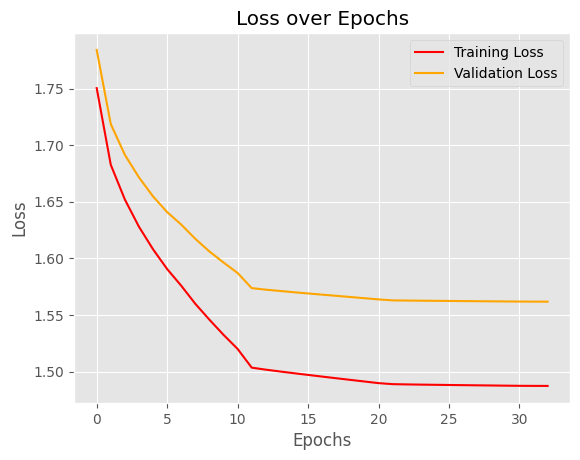

In [9]:
plt.plot(train_losses, label='Training Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [10]:
# Print the memory usage
print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak usage: {peak / 10**6:.2f} MB")

Current memory usage: 13.63 MB
Peak usage: 75.07 MB


## Model Evaluation

Accuracy: 0.4613
Precision: 0.4550
Recall: 0.4613
F1: 0.4558


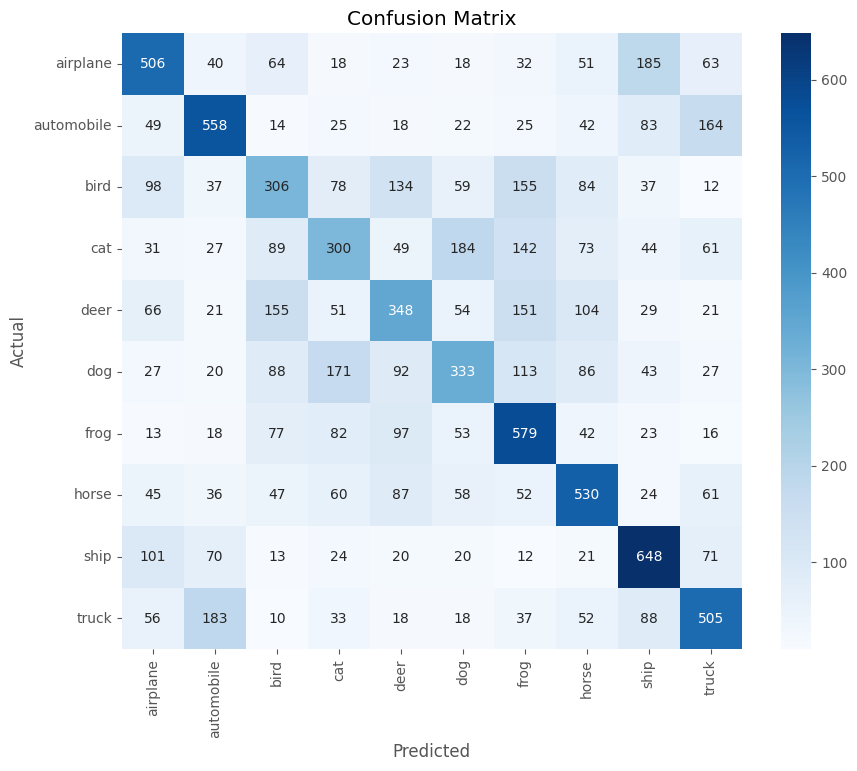

In [11]:
# Predict the test set
y_pred = model.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
], yticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Futher Usage

In [ ]:
# Save the model
joblib.dump(model, 'sklearn_model.pkl')

# Load the model
model = joblib.load('sklearn_model.pkl')

Text(0.5, 1.0, 'Predicted: 3 - Actual: 3')

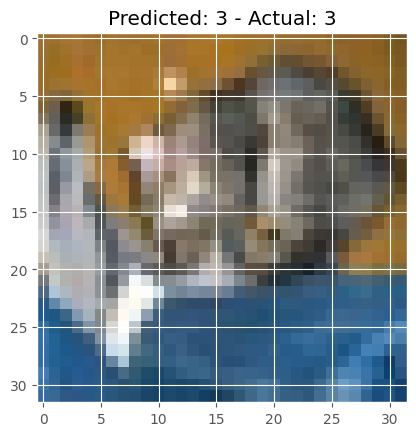

In [13]:
single_image = X_test[0]  # fist image in test
output = model.predict([single_image])
plt.imshow(single_image.reshape(32, 32, 3), cmap='gray')
plt.title(f'Predicted: {output[0]} - Actual: {y_test[0]}')